# P2 Dropout (Section 5.6)
1. What happens if you change the dropout probabilities for the first and second layers?
In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize
the qualitative takeaways.
2. What is the variance of the activations in each hidden layer when dropout is and is not
applied? Draw a plot to show how this quantity evolves over time for both models.
3. Using the model in this section as an example, compare the effects of using dropout
and weight decay. What happens when dropout and weight decay are used at the
same time? Are the results additive? Are there diminished returns (or worse)? Do
they cancel each other out? (you maybe interested in this undegrad honor thesis).

In [1]:
#!pip install d2l==1.0.3

# d2l importing
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

# libraries needed
import torch
from torch import nn
import d2l
from d2l import torch as d2l
import matplotlib.pyplot as plt

Mounted at /content/gdrive


# 1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.

Dropout probabilities: 0.8, 0.2


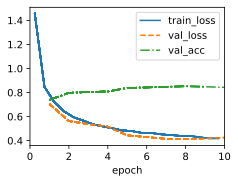

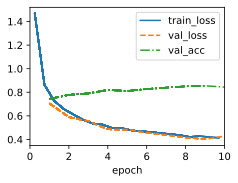

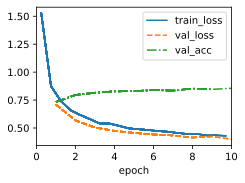

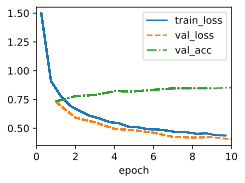

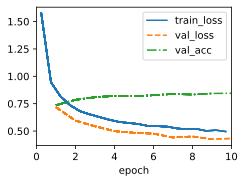

In [2]:
import torch
from torch import nn

class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

# Define hyperparameter combinations for different dropout setups
hparams_list = [
    {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
     'dropout_1': 0.5, 'dropout_2': 0.5, 'lr': 0.1},
    {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
     'dropout_1': 0.4, 'dropout_2': 0.6, 'lr': 0.1},
    {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
     'dropout_1': 0.6, 'dropout_2': 0.4, 'lr': 0.1},
    {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
     'dropout_1': 0.2, 'dropout_2': 0.8, 'lr': 0.1},
    {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
     'dropout_1': 0.8, 'dropout_2': 0.2, 'lr': 0.1}
]

# Train and evaluate each model with different dropout settings
for hparams in hparams_list:
    data = d2l.FashionMNIST(batch_size=256)
    model = DropoutMLP(**hparams)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)

    # Print model performance metrics (accuracy, loss, etc.)
    print(f"Dropout probabilities: {hparams['dropout_1']}, {hparams['dropout_2']}")


100%|██████████| 4/4 [06:09<00:00, 92.30s/it]


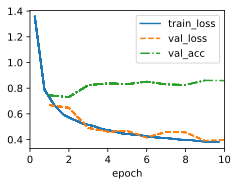

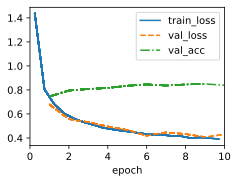

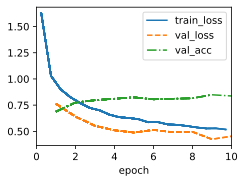

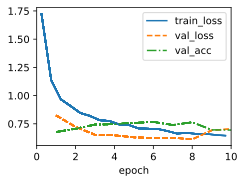

In [6]:
from tqdm import tqdm

class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)


def stat_dropout(dropouts):
    hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':dropouts,'lr':0.1}
    model = DropoutMLP(**hparams)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

dropout_list = [[0.1,0.5],[0.5,0.1],[0.1,0.9],[0.9,0.1]]
accs = []
for dropouts in tqdm(dropout_list):
    accs.append(stat_dropout(dropouts))

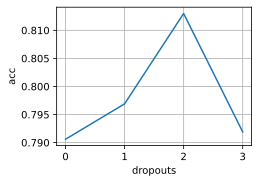

In [7]:
d2l.plot(list(range(len(dropout_list))),accs[-len(dropout_list):],'dropouts','acc')


The plot above shows that there is minimal difference when switching the probabilities of each layer. The difference between flipping the 1 and 0.5 probabilities (dropout iterations 0,1 in above plot) is about 0.005 and for 1 and 0.9 (iterations 2, 3) the change is 0.2.

We conclude that a small or negligible change in accuracy makes sense for this model due to its shallow nature. Even for the MNIST dataset, the addition of dropout only improves the accuracy by 1% so these results make sense.

# 2. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.

In [ ]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
data = d2l.FashionMNIST(batch_size=256)
model = DropoutMLP(**hparams)

trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [12]:
# MHR

class PlotActMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        self.activations = []
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3+4)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)

    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        if plot_flag:
            for i in self.activations:
                for j in range(2):
                    var = self.stat_activation_variance(i-j, *batch[:-1])
                    self.plot(f'layer_{i-j}',var,train=True)
        return self.loss(y_hat, batch[-1])

    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        return self.loss(y_hat, batch[-1])

    def stat_activation_variance(self, i, X):
        activation = self.net[:i](X)
        return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()

model.net

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

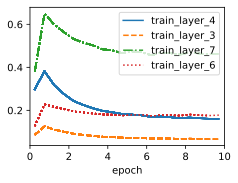

In [10]:
# TEST WITH 0.5 DROPOUT

hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0.5]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

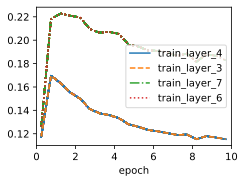

In [11]:
# TEST WITH NO DROPOUT

hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Comparing the two plots above, we see significantly lower variance for the model that does not implement dropout (avg of 0.2 compared to 0.6). The dropout mechanism explicitly introduces variability in the network's activations, causing different sets of neurons to be active or inactive for each training example. As a result, the variance of activations is expected to be higher with dropout, as different subsets of neurons contribute to the activations for a given input.

# 3. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out? (you maybe interested in this undegrad honor thesis).

In [15]:
class WeightDecayDropoutMLP(DropoutMLP):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts, weight_decay):
        super().__init__(num_outputs, num_hiddens, lr, dropouts)
        self.save_hyperparameters()

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

def stat_weight_decay(dropouts, weight_decay, data):
    hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':dropouts,'lr':0.1,'weight_decay':weight_decay}
    model = WeightDecayDropoutMLP(**hparams)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()


100%|██████████| 2/2 [06:14<00:00, 187.02s/it]


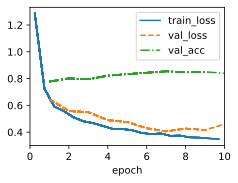

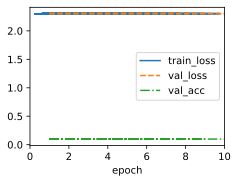

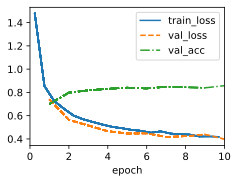

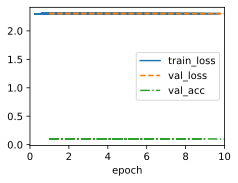

In [16]:
# First try weight decay of 0.5

dropout_list = [[0]*2,[0.5]*2]
decay_list = [0,0.5]
accs = []
for dropouts in tqdm(dropout_list):
    for weight_decay in tqdm(decay_list):
        accs.append(stat_weight_decay(dropouts, weight_decay, data))

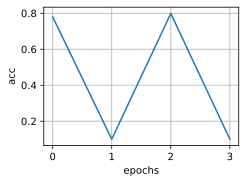

In [17]:
d2l.plot(list(range(len(accs))),accs,'epochs','acc')


While dropout and weight decay address different aspects of regularization, they can be used together, and their effects are generally complementary.
When used together, dropout and weight decay often work well to provide complementary regularization effects. The results are not simply additive, as they address different aspects of the model's behavior.

When they work together, both methods help prevent the model from overfitting to the training data.

Dropout and weight decay do not "cancel each other out" but due to their independent effects on the model, the combined results sometimes are not ideal and parameter values need to be chosen wisely to avoid this. In these first series of plots, we can see that decay of value 0.5 is simply way too large of a parameter and the plot suggests that weight decay hurts the accuracy of the model.


100%|██████████| 2/2 [06:11<00:00, 185.96s/it]


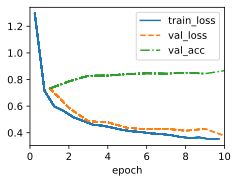

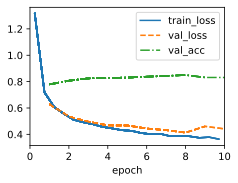

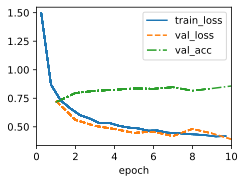

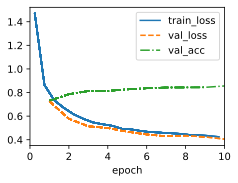

In [20]:
# Now try much smaller, more realistic weight decay value
dropout_list = [[0]*2,[0.5]*2]
decay_list = [0,0.001]
accs = []
for dropouts in tqdm(dropout_list):
    for weight_decay in tqdm(decay_list):
        accs.append(stat_weight_decay(dropouts, weight_decay, data))

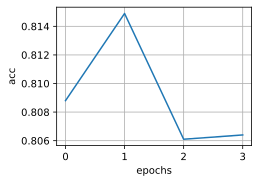

In [21]:
d2l.plot(list(range(len(accs))),accs,'epochs','acc')


This next iteration using weight decay of 0.001 seems to make it unclear whether the combined effects of WD and dropout make any difference.

Existing research has shown that weight decay is more useful in networks with a smaller propensity to overfit—that is, networks with lower complexity and more training data.

Therefore, a possible guideline is to use dropout when the network is very large and complex compared to the amount of data, and use weight decay when the network is relatively simple or the data is abundant. Alternatively, one can try different combinations of dropout and weight decay and select the best one based on validation performance.